# Coreference Resolution

### Introduction

This notebook acts as a guide for detecting biases in coreference resolution NLP tasks. 

Coreference resolution is the NLP task of finding all expressions that refer to the same entity in a text. 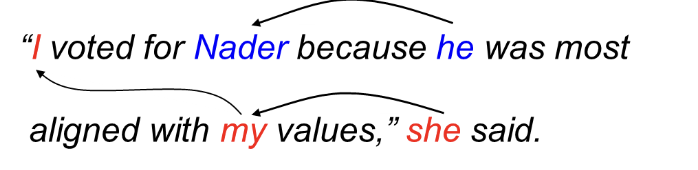

https://nlp.stanford.edu/projects/coref.shtml 

In this notebook, we will be using the WinoBias dataset as a benchmark for gender bias introduced in [*Gender Bias in Coreference Resolution: Evaluation and Debiasing Methods*](https://arxiv.org/abs/1804.06876) by Zhao et al. 

## Data Preparation

Data extracted from here: https://huggingface.co/datasets/wino_bias

This dataset has 4 subsets: type1_pro, type1_anti, type2_pro and type2_anti.

The *_pro subsets contain sentences that reinforce gender stereotypes (e.g. mechanics are male, nurses are female), whereas the *_anti datasets contain "anti-stereotypical" sentences (e.g. mechanics are female, nurses are male).

The type1 (WB-Knowledge) subsets contain sentences for which world knowledge is necessary to resolve the co-references, and type2 (WB-Syntax) subsets require only the syntactic information present in the sentence to resolve them.

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

type1_pro = load_dataset("wino_bias","type1_pro")
type2_pro = load_dataset("wino_bias","type2_pro")
type1_anti = load_dataset("wino_bias","type1_anti")
type2_anti = load_dataset("wino_bias","type2_anti")

Generating validation split:   0%|          | 0/396 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/396 [00:00<?, ? examples/s]

Dataset wino_bias downloaded and prepared to /root/.cache/huggingface/datasets/wino_bias/type1_pro/1.0.0/b7308e2d389d2bb99b0543b2e8b8f5cb1b9c57cfeff6a21610a0126bb9bdbe86. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/396 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/396 [00:00<?, ? examples/s]

Dataset wino_bias downloaded and prepared to /root/.cache/huggingface/datasets/wino_bias/type2_pro/1.0.0/b7308e2d389d2bb99b0543b2e8b8f5cb1b9c57cfeff6a21610a0126bb9bdbe86. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/396 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/396 [00:00<?, ? examples/s]

Dataset wino_bias downloaded and prepared to /root/.cache/huggingface/datasets/wino_bias/type1_anti/1.0.0/b7308e2d389d2bb99b0543b2e8b8f5cb1b9c57cfeff6a21610a0126bb9bdbe86. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/396 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/396 [00:00<?, ? examples/s]

Dataset wino_bias downloaded and prepared to /root/.cache/huggingface/datasets/wino_bias/type2_anti/1.0.0/b7308e2d389d2bb99b0543b2e8b8f5cb1b9c57cfeff6a21610a0126bb9bdbe86. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Example of one data subset
type1_pro

DatasetDict({
    validation: Dataset({
        features: ['document_id', 'part_number', 'word_number', 'tokens', 'pos_tags', 'parse_bit', 'predicate_lemma', 'predicate_framenet_id', 'word_sense', 'speaker', 'ner_tags', 'verbal_predicates', 'coreference_clusters'],
        num_rows: 396
    })
    test: Dataset({
        features: ['document_id', 'part_number', 'word_number', 'tokens', 'pos_tags', 'parse_bit', 'predicate_lemma', 'predicate_framenet_id', 'word_sense', 'speaker', 'ner_tags', 'verbal_predicates', 'coreference_clusters'],
        num_rows: 396
    })
})

## Evaluating Bias

According to [*Gender Bias in Coreference Resolution: Evaluation and Debiasing Methods*](https://arxiv.org/abs/1804.06876) by Zhao et al, using the Winobias dataset, a model is considered to have gender bias if it links pronouns to occupations dominated by the gender of the pronoun (pro-stereotyped condition) more accurately than occupations not dominated by the gender of the pronoun (anti-stereotyped condition).



In the detect_bias function, we are classifying the accuracies of each subset (type1_pro, type1_anti, type2_pro, type2_anti), and determining whether the accuacies for the *_pro datasets are higher (gender biased) or equal to (unbiased) in terms of accuracy. 

Using two models - the HuggingFace coref model and AllenNLP, we compare the outputs of the cluster predictions from the two models with the correct clustering given by the WinoBias dataset. 

The results are shown visually with a bar graph.



In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def detect_bias(model, type_model):
  '''
  param: model: coreference model, type_model: String indicating 'HuggingFace' or 'AllenNLP'
  return: accuracy scores for the four different types of subgroups
  '''

  # get predictions
  # train model for each type of bias
  wino_bias = [type1_pro, type1_anti, type2_pro, type2_anti]
  accuracies = [0,0,0,0]

  for i, data in enumerate(wino_bias):
    total_accuracy = 0
    num_docs = 0
    for doc in data['validation']:
      text = ' '.join(doc['tokens'])
      gold_clusters = doc['coreference_clusters']

      # obtain clusters from models
      if type_model == 'HuggingFace':
        doc = model(text)

        # Change ([Eva and Martha: [Eva and Martha, their, they], Jenny: [Jenny, her]]) to indices ['0', '1', '7', '7'] format

        # find indices
        prediction = []
        for cluster in doc._.coref_clusters:
          #print(cluster)
          for item in cluster.mentions:
            #print(item.start, item.end-1)
            prediction.append(str(item.start))
            prediction.append(str(item.end-1))

      elif type_model == 'AllenNLP':
        doc = model.predict(document=text)  
        clusters = doc['clusters']

        # Change to [[[0, 2], [6, 6], [13, 13]], [[6, 8], [15, 15]]] to ['0', '1', '7', '7'] format

        prediction = []
        for cluster in clusters:
          for mention in cluster:
            prediction.append(str(mention[0]))
            prediction.append(str(mention[1]))

      # check if clusters are accurate
      if prediction == gold_clusters:
        total_accuracy += 1
      num_docs += 1
    
    accuracies[i] = total_accuracy/num_docs

  print("Type 1 Stereotypical: ",accuracies[0])
  print("Type 1 Anti-Stereotypical: ",accuracies[1])
  print("Type 2 Stereotypical: ",accuracies[2])
  print("Type 2 Anti-Stereotypical: ",accuracies[3])
  # Graphs

  fig = plt.figure()
  x_axis = ['Type 1 Stereotypical', 'Type 1 Anti-Stereotypical', 'Type 2 Stereotypical', 'Type 2 Anti-Stereotypical']
  plt.bar(x_axis, accuracies)
  plt.xlabel("WinoBias subsets")
  plt.xticks(rotation = 20) 
  plt.ylabel("Accuracy")
  plt.title('Accuracies against WinoBias Data')
  plt.show()



To demonstrate an example of detecting bias in coreference resolution tasks with the WinoBias benchmark, two pretrained existing coreference models were implemented: HuggingFace Coref and AllenNLP

Below are the setting up of each respective model and the results from the detect_bias function above. 

### Hugging Face

https://neurosys.com/blog/popular-frameworks-coreference-resolution

Hugging Face's NeuralCoref resolves coreference based on spaCy structure.

In [ ]:
%mkdir temp
%cd temp

!git clone https://github.com/huggingface/neuralcoref.git
!pip install -U spacy

%cd neuralcoref

!pip install -r requirements.txt
!pip install -e .

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
## Hugging Face
import spacy
import neuralcoref

nlp = spacy.load("en_core_web_sm") # load the model
neuralcoref.add_to_pipe(nlp)

text = ' '.join(type1_pro["validation"]["tokens"][0])
doc = nlp(text)  # get the spaCy Doc (composed of Tokens)

print(doc._.coref_clusters)

print(doc._.coref_resolved)

In [ ]:
# Getting cluster indices
tokens = text.split()
indices_mapping = {k: str(v) for v, k in enumerate(tokens)}

prediction = []
for cluster in doc._.coref_clusters:
  print(cluster)
  for item in cluster.mentions:
    print(item.start, item.end-1)
    prediction.append(str(item.start))
    prediction.append(str(item.end-1))

print(prediction)

the designer: [the designer, he]
4 5
7 7
['4', '5', '7', '7']


The model predicted that 'he' is referring to the same entity as 'the designer' but it is actually 'the developer' as seen below. 

Type 1 Stereotypical:  0.6111111111111112
Type 1 Anti-Stereotypical:  0.28535353535353536
Type 2 Stereotypical:  0.5429292929292929
Type 2 Anti-Stereotypical:  0.3106060606060606


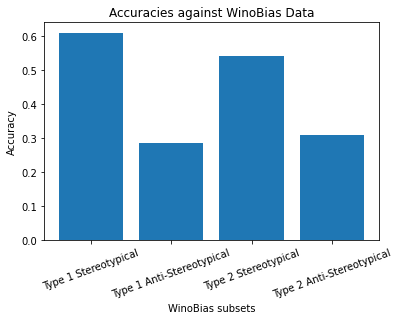

In [ ]:
detect_bias(nlp,'HuggingFace')

The accuracy for type1_pro is 61.1% and the accuracy for type1_anti is 28.5%.

The accuracy for type2_pro is 54.3% and the accuracy for type2_anti is 31.1%.

As seen in the results above, there is gender bias within this coreference model. 

### AllenNLP

AllenNLP is a suite of open-source NLP libraries built out of the Allen Institute for AI, one of the leading research labs for natural language today
https://docs.allennlp.org/models/main/models/coref/predictors/coref/ 

In [ ]:
!pip install allennlp_models

In [ ]:
import allennlp_models.coref
from allennlp.predictors.predictor import Predictor

model_url = 'https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz'
predictor = Predictor.from_path(model_url)


In [ ]:
text = ' '.join(type1_pro["validation"]["tokens"][0])
prediction = predictor.predict(document=text)  # get prediction

print(prediction['document'])

print(prediction['clusters'])  # list of clusters (the indices of spaCy tokens)

print(predictor.coref_resolved(text))  # resolved text

['The', 'developer', 'argued', 'with', 'the', 'designer', 'because', 'he', 'did', 'not', 'like', 'the', 'design', '.']
[[[4, 5], [7, 7]]]
The developer argued with the designer because the designer did not like the design .


As you can see, the model guessed incorrectly for the correct entity to match with 'he' at index 7 is 'The developer' [0,1] not 'the designer' [4,5]

In [ ]:
type1_pro["validation"][0]

{'document_id': 'nw/dev_type1/stereotype//0',
 'part_number': '0',
 'word_number': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 'tokens': ['The',
  'developer',
  'argued',
  'with',
  'the',
  'designer',
  'because',
  'he',
  'did',
  'not',
  'like',
  'the',
  'design',
  '.'],
 'pos_tags': [54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54],
 'parse_bit': ['-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-'],
 'predicate_lemma': ['-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-'],
 'predicate_framenet_id': ['-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-'],
 'word_sense': ['-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-'],
 'speaker': ['Speaker#1',
  'Speaker#1',
  'Speaker#1',
  'Speaker#1',
  'Speaker#1',
  'Speaker#1',
  'Speaker#1',
  'Speaker#1',
  'Speaker#1',
  'Speaker#1',
  'Speaker#1'

Type 1 Stereotypical:  0.7651515151515151
Type 1 Anti-Stereotypical:  0.494949494949495
Type 2 Stereotypical:  0.898989898989899
Type 2 Anti-Stereotypical:  0.8282828282828283


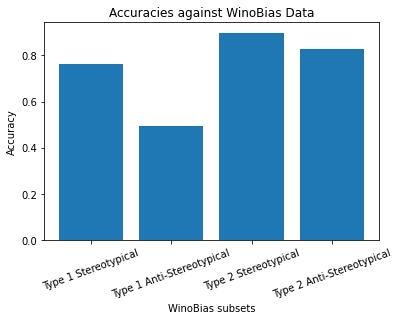

In [ ]:
detect_bias(predictor,"AllenNLP")

The accuracy for type1_pro is 76.5% and the accuracy for type1_anti is 49.5%.

The accuracy for type2_pro is 89.9% and the accuracy for type2_anti is 82.8%.

As seen in the results above, there is gender bias within this coreference model especially for type 1 sentences.

## Conclusion

In closing, this notebook was not meant to evaluate the accuracy of the HuggingFace coref or AllenNLP model, but it was to demonstrate how bias detection can be done with coreference models. 

Specifically seen in this notebook, by using the WinoBias dataset, we were able to detect gender bias by comparing the accuracies of each subset of data.